In [1]:
pip install numpy==1.23

Note: you may need to restart the kernel to use updated packages.


In [64]:
import pandas as pd
import numpy as np
np.float_ = np.float64
from prophet import Prophet

from sklearn.model_selection import train_test_split
from prophet.serialize import model_to_json, model_from_json

In [65]:
symbol_prices = pd.read_csv('../out/symbols_prices.csv', sep=';', encoding='utf-8')


In [66]:
symbol_prices.Symbol.value_counts()

Symbol
BTCEUR     1116
ETHEUR     1116
DOGEEUR    1116
Name: count, dtype: int64

In [71]:
def prepare_money_to_model(symbol_prices, symbol):
    df_money = symbol_prices[symbol_prices.Symbol == symbol][['timestamp','close']]
    df_money = df_money.rename(columns={'timestamp': 'ds', 'close': 'y'})
    return df_money


def apply_prophet_model(money_train):
    model_prophet = Prophet()
    model_prophet.fit(money_train)
    return model_prophet

def save_model(model_prophet, symbol):
    with open('../model/serialized_model_for_'+str(symbol)+'.json', 'w') as fout:
        fout.write(model_to_json(model_prophet))  # Save model

def load_model(symbol):
    with open('../model/serialized_model_for_'+str(symbol)+'.json', 'r') as fin:
        m = model_from_json(fin.read())  # Load model
    return m



In [93]:
# Workflow BTC
df_money= prepare_money_to_model(symbol_prices, 'BTCEUR')

money_train, money_test = train_test_split(df_money, 
                                           test_size=0.02, 
                                           shuffle=False,
                                           random_state = 42)

model_prophet = apply_prophet_model(money_train)
money_future = model_prophet.make_future_dataframe(periods=len(money_test), freq='B')
money_predit = model_prophet.predict(money_future)

save_model(model_prophet, 'BTCEUR')



13:52:36 - cmdstanpy - INFO - Chain [1] start processing
13:52:37 - cmdstanpy - INFO - Chain [1] done processing


In [94]:
m = load_model('BTCEUR')

money_future = m.make_future_dataframe(periods=len(money_test), freq='B')
money_predit = m.predict(money_future)


/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



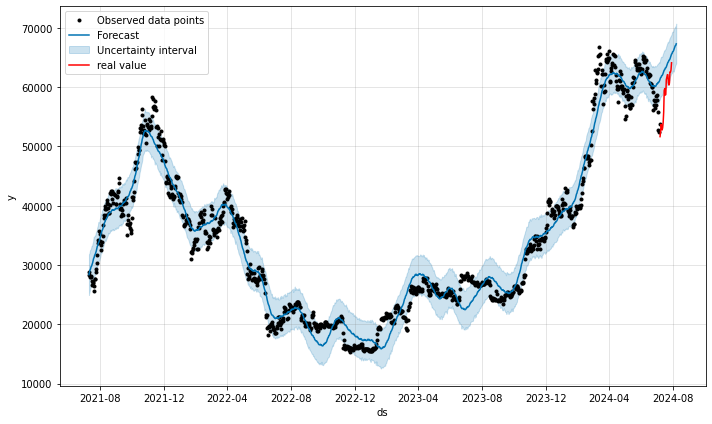

In [95]:
import matplotlib.pyplot as plt 
fig1 = m.plot(money_predit)

# Ajout de la courbe de test
plt.plot(pd.to_datetime(money_test['ds']), money_test['y'], 'r', label='real value')  # 'r' est la couleur rouge
plt.legend()
plt.show()


In [97]:
from prophet.plot import plot_plotly
import plotly.graph_objs as go
plot_plotly(m, money_predit)


/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



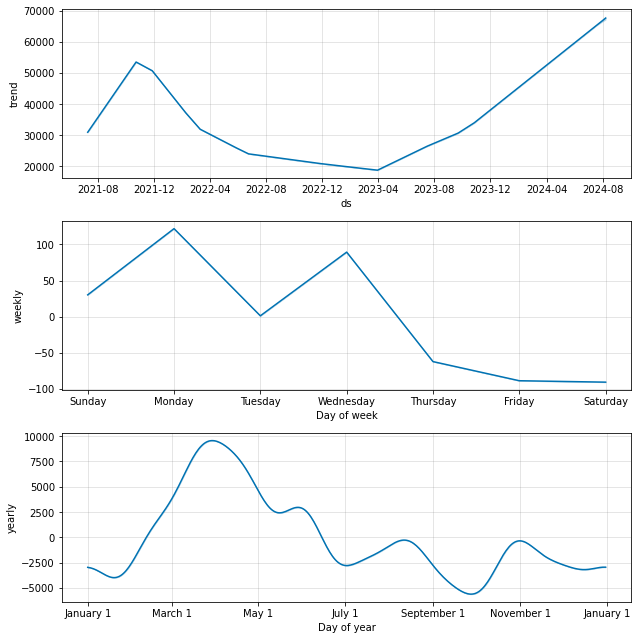

In [98]:
fig2 = m.plot_components(money_predit)

/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



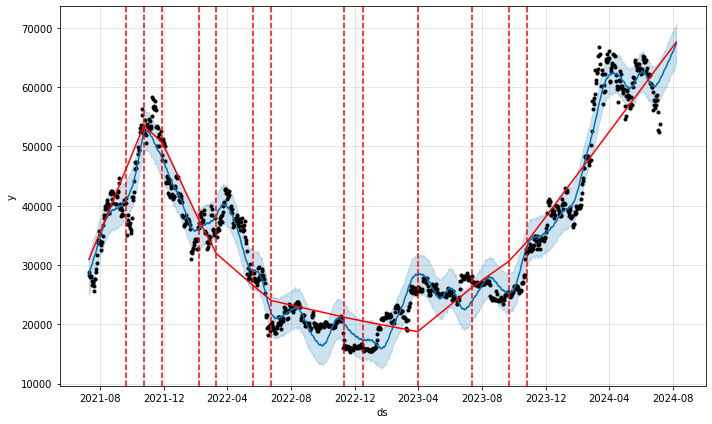

In [99]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(money_predit)
a = add_changepoints_to_plot(fig.gca(), model_prophet, money_predit)

In [81]:
# Python
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='365 days', period='90 days', horizon = '7 days')


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/9 [00:00<?, ?it/s]

13:36:25 - cmdstanpy - INFO - Chain [1] start processing
13:36:26 - cmdstanpy - INFO - Chain [1] done processing
 11%|█         | 1/9 [00:00<00:01,  5.97it/s]13:36:26 - cmdstanpy - INFO - Chain [1] start processing
13:36:26 - cmdstanpy - INFO - Chain [1] done processing
 22%|██▏       | 2/9 [00:00<00:01,  5.09it/s]13:36:26 - cmdstanpy - INFO - Chain [1] start processing
13:36:26 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 3/9 [00:00<00:01,  4.45it/s]13:36:26 - cmdstanpy - INFO - Chain [1] start processing
13:36:26 - cmdstanpy - INFO - Chain [1] done processing
 44%|████▍     | 4/9 [00:00<00:01,  4.17it/s]13:36:26 - cmdstanpy - INFO - Chain [1] start processing
13:36:27 - cmdstanpy - INFO - Chain [1] done processing
 56%|█████▌    | 5/9 [00:01<00:01,  3.66it/s]13:36:27 - cmdstanpy - INFO - Chain [1] start processing
13:36:27 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 6/9 [00:01<00:00,  3.43it/s]13:36:27 - cmdstanpy - INFO - Chain [1] start proces

In [82]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,6.756078e+06,2599.245605,2208.883373,0.086168,0.075648,0.087352,0.444444
1,2 days,8.881952e+06,2980.260459,2656.974762,0.101300,0.066180,0.101299,0.333333
2,3 days,1.126537e+07,3356.392501,2952.298153,0.108689,0.087067,0.109540,0.333333
3,4 days,1.318292e+07,3630.829451,2968.147305,0.111420,0.087027,0.113657,0.555556
4,5 days,2.014582e+07,4488.409781,3454.391134,0.124019,0.083854,0.126997,0.555556
5,6 days,2.406569e+07,4905.678861,3758.287728,0.138860,0.081396,0.144196,0.555556
6,7 days,2.872263e+07,5359.349661,4363.329016,0.162098,0.138995,0.171294,0.444444


In [132]:
money_predit.tail(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
177,2024-08-08,65737.418683,60359.693494,70908.819871,61154.289229,70223.391284,113.809145,113.809145,113.809145,113.809145,113.809145,113.809145,0.0,0.0,0.0,65851.227828
178,2024-08-09,65796.940313,59649.039822,71161.486565,61005.177832,70436.561261,-128.638319,-128.638319,-128.638319,-128.638319,-128.638319,-128.638319,0.0,0.0,0.0,65668.301993
179,2024-08-12,65975.505203,60987.759036,72505.227261,60889.490595,70808.220624,780.423861,780.423861,780.423861,780.423861,780.423861,780.423861,0.0,0.0,0.0,66755.929063


In [133]:
money_test.tail(3)

,ds,y
1113,2024-07-27,62490.99
1114,2024-07-28,62893.43
1115,2024-07-29,64101.32


In [223]:
def get_wallet():
    try:
        # Essayer de lire le fichier CSV
        wallet = pd.read_csv('../out/wallet.csv', sep=';', encoding='utf-8')
        return wallet
    except FileNotFoundError as e:
        # Gérer le cas où le fichier est introuvable
        print(f"Fichier non trouvé, initialisation du portefeuille: {e}")
        wallet = pd.DataFrame({'timestamp': [datetime.now()],'fonds_disponibles': [10000], 'btc': [0], 'eth': [0], 'doge': [0], 'fonds_investis':[0]})
        wallet.to_csv('../out/wallet.csv', header =True, sep=';', encoding='utf-8', index=False)
        return wallet
wallet = get_wallet()    

Fichier non trouvé, initialisation du portefeuille: [Errno 2] No such file or directory: '../out/wallet.csv'


In [231]:
def get_action(wallet, symbol):
    # Obtenir le dernier index des données du portefeuille
    last_index = wallet.index[-1]
    
    # Obtenir le timestamp actuel
    current_time = datetime.now()
    
    # Simule obtenir les prix actuels (remplacez cette fonction par votre fonction réelle)
    prices = get_current_price()
    
    # Simule obtenir le choix de l'action (remplacez cette fonction par votre fonction réelle)
    action_choice = get_choice(symbol, prices)
    
    # Obtenir le prix actuel de la crypto-monnaie sélectionnée
    current_price = float(prices.get(symbol)[0].get('price'))

    # Création d'une nouvelle ligne avec le timestamp actuel et les données du dernier portefeuille
    new_row = wallet.iloc[[last_index]].copy()
    new_row['timestamp'] = current_time

    if action_choice == 'Buy':
        if wallet.loc[last_index, 'fonds_disponibles'] > 0:
            # Calculer combien on peut acheter de la crypto sélectionnée avec les fonds disponibles
            amount_to_buy = 100 / current_price  # Exemple : acheter pour 100 USD
            new_row.at[last_index, 'fonds_disponibles'] -= 100  # Déduire le montant en USD
            new_row.at[last_index, symbol.lower()[:-3]] += float(amount_to_buy)  # Ajouter la crypto achetée
            new_row.at[last_index, 'fonds_investis'] += 100  # Mettre à jour les fonds investis
            print(f"Action : Acheter {amount_to_buy:.6f} {symbol} au prix de {current_price:.2f} USD/{symbol}.")
        else:
            print("Action : Acheter impossible. Fonds insuffisants.")
    
    elif action_choice == 'Sell':
        if wallet.loc[last_index, symbol.lower()[:-3]] > 0:
            # Calculer combien d'USD on recevra en vendant une certaine quantité de la crypto sélectionnée
            amount_to_sell = 0.01  # Exemple : vendre 0.01 de la crypto
            amount_received = amount_to_sell * current_price
            new_row.at[last_index, 'fonds_disponibles'] += amount_received  # Ajouter les fonds reçus
            new_row.at[last_index, symbol.lower()[:-3]] -= float(amount_to_sell) # Déduire la crypto vendue
            new_row.at[last_index, 'fonds_investis'] -= amount_received  # Mettre à jour les fonds investis
            print(f"Action : Vendre {amount_to_sell:.6f} {symbol} au prix de {current_price:.2f} USD/{symbol}.")
        else:
            print(f"Action : Vendre impossible. {symbol} insuffisants.")
    
    else:
        print("Action non reconnue. Veuillez choisir 'Buy' ou 'Sell'.")
    
    # Ajouter la nouvelle ligne au DataFrame
    wallet = pd.concat([wallet, new_row], ignore_index=True)
    
    return wallet

In [232]:
print(get_choice('BTCEUR', prices))
wallet = get_action(wallet,'BTCEUR')
wallet = get_action(wallet,'ETHEUR')
wallet = get_action(wallet,'DOGEEUR')
wallet

Buy
Action : Acheter 0.001606 BTCEUR au prix de 62284.52 USD/BTCEUR.
Action : Acheter 0.032628 ETHEUR au prix de 3064.81 USD/ETHEUR.
Action : Vendre impossible. DOGEEUR insuffisants.


,timestamp,fonds_disponibles,btc,eth,doge,fonds_investis
0,2024-07-29 19:18:14.782298,10000,0.000000,0.000000,0,0
1,2024-07-29 19:22:23.094818,9900,0.001606,0.000000,0,100
2,2024-07-29 19:22:24.957587,9800,0.001606,0.032626,0,200
3,2024-07-29 19:22:27.007314,9800,0.001606,0.032626,0,200
4,2024-07-29 19:23:08.957700,9700,0.003212,0.032626,0,300
5,2024-07-29 19:23:11.344272,9600,0.003212,0.065255,0,400
6,2024-07-29 19:23:13.447019,9600,0.003212,0.065255,0,400


In [186]:
from binance.client import Client
api_key = 'Q2ScRTFxPN3auqFzSwTARZjwyReBBqvGj6o62mwHs8dE3sq6ghkrwbcmAHIIFPB9'
secret = 'YbYojfUG1Ysk1Wg6yAHt1fZmQ47Jq8fKBkIXu3JZn41XzK1G9LnJHRiIyYhx8zWH'
client = Client(api_key= api_key, api_secret=secret)


def get_current_price():
    results = {}
    interval='1d'
    symbols = ['BTCEUR', 'ETHEUR','DOGEEUR']

    # Obtenir le temps de fin (temps actuel)
    end_time = datetime.now()
    # Calculer le temps de début (1 jour dans cet exemple)
    start_time = end_time - timedelta(days=1)  # Environ 1 jour

    # Convertir start_time et end_time en millisecondes pour l'API
    start_time_str = start_time.strftime('%Y-%m-%d %H:%M:%S')
    end_time_str = end_time.strftime('%Y-%m-%d %H:%M:%S')

    for symbol in symbols:
        # Fetch historical klines data
        klines = client.get_historical_klines(symbol, interval, start_time_str, end_time_str)
        
        # Définir les colonnes pour le DataFrame
        spot_kline_cols = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']

        # Convertir les données des klines en DataFrame
        df = pd.DataFrame(klines, columns=spot_kline_cols)

        # Convertir les colonnes temporelles en datetime
        df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
        df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')

        # Extraire le prix de fermeture et stocker dans le dictionnaire de résultats
        results[symbol] = df[['close']].rename(columns={'close': 'price'}).to_dict(orient='records')
    return results

In [187]:
prices = get_current_price()

In [203]:
def get_predict_price(symbol):
    m = load_model(symbol)
    future_df = pd.DataFrame({'ds': [datetime.now() + timedelta(days=7)]})
    predicted_value = float(m.predict(future_df).yhat.iloc[0])
    return predicted_value

def get_choice(symbol, prices):
    if get_predict_price(symbol) > float(prices.get(symbol)[0].get('price')): return 'Buy'
    elif get_predict_price(symbol) < float(prices.get(symbol)[0].get('price')): return 'Sell'

In [199]:
get_choice('BTCEUR',prices)

'Buy BTCEUR'

In [220]:
prices

{'BTCEUR': [{'price': '61872.84000000'}],
 'ETHEUR': [{'price': '3055.34000000'}],
 'DOGEEUR': [{'price': '0.11890000'}]}